<a href="https://colab.research.google.com/github/danilobarrote/AMCD---Modelagem-e-Previs-o-de-S-ries-Temporais-Financeiras/blob/main/trabalhoAMCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import de libs

In [1]:
pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 10.2 MB/s eta 0:00:00


In [2]:
# Manipulação e análise de dados
import pandas as pd
import numpy as np

# Coleta de dados financeiros
import yfinance as yf
from datetime import datetime, timedelta

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.preprocessing import MinMaxScaler

# Modelos estatísticos
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# Modelos de Machine Learning
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Tunagem de hiperparâmetros
!pip install -q keras-tuner
import keras_tuner as kt



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 2.4 MB/s eta 0:00:00


# Ingestão de dados

In [3]:

# Define the ticker symbol
ticker = "PETR4.SA"

# Calculate the start date for the last 10 years
end_date = datetime.now()
start_date = end_date - timedelta(days=10*365) # Approximate 10 years

# Download the stock data
data = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows of the data
print(data.head())

/tmp/ipython-input-3224160403.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open    Volume
Ticker      PETR4.SA  PETR4.SA  PETR4.SA  PETR4.SA  PETR4.SA
Date                                                        
2015-12-21  1.824942  1.948620  1.819445  1.940375  54032100
2015-12-22  1.866169  1.874414  1.819446  1.857924  40463400
2015-12-23  1.904646  1.934878  1.888155  1.899149  38789700
2015-12-28  1.841432  1.896400  1.827690  1.896400  28617600
2015-12-29  1.838685  1.888156  1.835936  1.871666  22441300


# Limpeza e qualidade - Pré-processamento de dados

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2489 entries, 2015-12-21 to 2025-12-16
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Close, PETR4.SA)   2489 non-null   float64
 1   (High, PETR4.SA)    2489 non-null   float64
 2   (Low, PETR4.SA)     2489 non-null   float64
 3   (Open, PETR4.SA)    2489 non-null   float64
 4   (Volume, PETR4.SA)  2489 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 116.7 KB


Aqui colhemos as informações básicas sobre cada feature.

In [5]:
data.isna().sum()

,,0
Price,Ticker,
Close,PETR4.SA,0
High,PETR4.SA,0
Low,PETR4.SA,0
Open,PETR4.SA,0
Volume,PETR4.SA,0


A base de dados já está limpa, sem células vazias.

# Análise Exploratória

***Análise Estatística Básica das Variáveis OHLCV***

In [6]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
stats_df = data[features].copy()

stats_df.describe()


Price,Open,High,Low,Close,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
count,2489.000000,2489.000000,2489.000000,2489.000000,2.489000e+03
mean,13.193316,13.358038,13.023907,13.189040,5.799994e+07
std,10.417483,10.508744,10.326176,10.416190,3.382580e+07
min,1.154331,1.173569,1.132343,1.154331,0.000000e+00
25%,5.286917,5.381383,5.157160,5.245505,3.597700e+07
50%,8.268834,8.384135,8.142226,8.240162,5.113370e+07
75%,20.460364,20.859761,20.327232,20.593494,7.108760e+07
max,35.690561,35.810985,35.486780,35.662777,4.902304e+08


A Tabela apresenta estatísticas descritivas básicas das variáveis OHLCV da ação PETR4 ao longo do período analisado. Observa-se que as variáveis de preço (Open, High, Low e Close) apresentam valores médios e medianos próximos entre si, indicando comportamento consistente e forte relação entre os diferentes tipos de preço observados no mesmo pregão.

Os valores de desvio padrão evidenciam elevada dispersão dos preços ao longo do tempo, refletindo a volatilidade característica do mercado acionário. Nota-se também uma assimetria na distribuição dos preços, uma vez que os valores máximos são significativamente superiores aos valores medianos, sugerindo períodos de apreciação acentuada do ativo.

Em relação ao volume de negociação, verifica-se elevada variabilidade, com grande amplitude entre os valores mínimo e máximo e desvio padrão expressivo. Esse comportamento indica oscilações relevantes na intensidade de negociação da ação, associadas a diferentes regimes de mercado e eventos específicos ao longo do período analisado.


***Análise Univariada – Boxplot do Close***

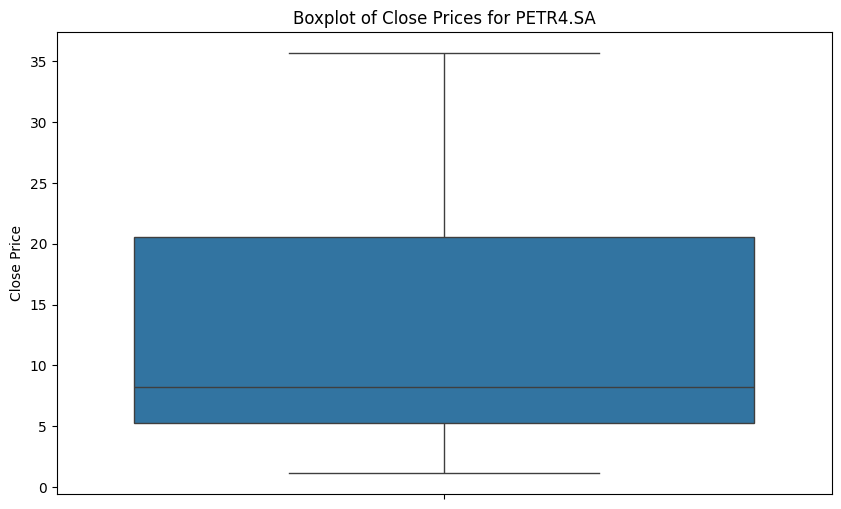

In [7]:


plt.figure(figsize=(10, 6))
sns.boxplot(y=data[('Close', 'PETR4.SA')])
plt.title('Boxplot of Close Prices for PETR4.SA')
plt.ylabel('Close Price')
plt.show()

Este gráfico mostra que a PETR4.SA tem um histórico de preços concentrado em valores mais baixos (mediana ~R\$ 8), mas com potencial de valorização significativo (chegando a R\$ 36), apresentando uma distribuição de dados bastante dispersa e volátil.

***ANÁLISE BIVARIADA entre os atributos OHCLV***

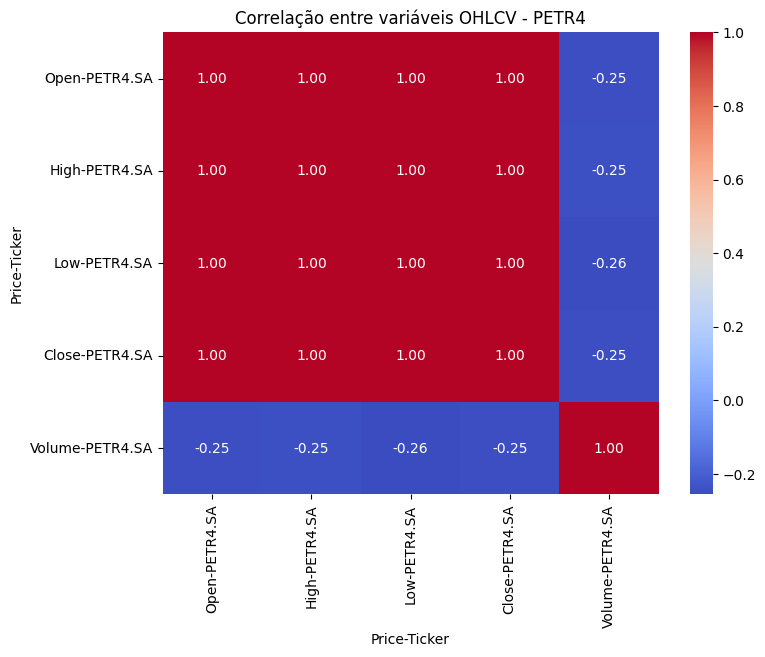

In [8]:


ohlcv = data[['Open', 'High', 'Low', 'Close', 'Volume']]

plt.figure(figsize=(8,6))
sns.heatmap(ohlcv.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlação entre variáveis OHLCV - PETR4")
plt.show()




A Figura  apresenta a matriz de correlação entre as variáveis OHLCV da ação PETR4. Observa-se elevada correlação linear entre as variáveis de preço (Open, High, Low e Close), indicando forte colinearidade, o que é esperado devido à natureza intrínseca desses atributos, uma vez que representam diferentes medidas de preço no mesmo período de negociação.

Por outro lado, a variável Volume apresentou correlação negativa e de baixa magnitude em relação às variáveis de preço, sugerindo uma relação menos linear. Esse comportamento é característico de séries financeiras, nas quais o volume de negociação está associado à intensidade do mercado, mas não necessariamente à direção dos preços.

Essa análise evidencia a presença de redundância entre as variáveis de preço e reforça a importância da etapa de engenharia de features, bem como da utilização de modelos capazes de capturar relações não lineares.


***Analise Multivariada***

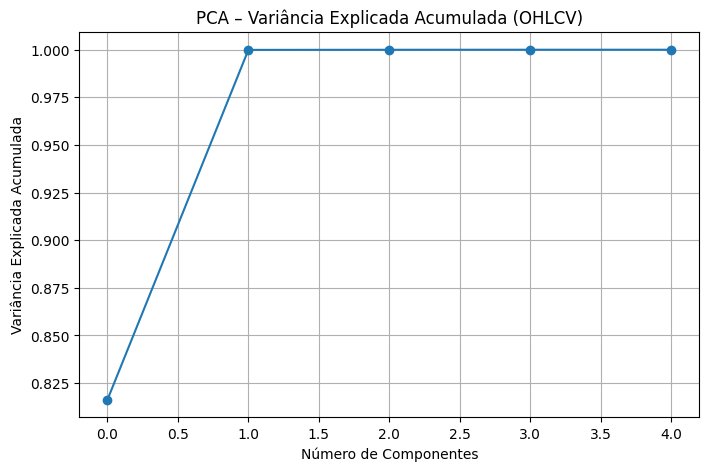

In [9]:
features_pca = ['Open', 'High', 'Low', 'Close', 'Volume']

X = data[features_pca]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,5))
plt.plot(
    np.cumsum(pca.explained_variance_ratio_),
    marker='o'
)
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('PCA – Variância Explicada Acumulada (OHLCV)')
plt.grid(True)
plt.show()

pca_df = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Variância Explicada': pca.explained_variance_ratio_,
    'Variância Acumulada': np.cumsum(pca.explained_variance_ratio_)
})
pca_df.to_csv("pca_variancia_explicada_PETR4.csv", index=False)









A Figura  apresenta a variância explicada acumulada obtida pela Análise de Componentes Principais aplicada às variáveis OHLCV da ação PETR4. Observa-se que o primeiro componente principal é responsável por aproximadamente 82\% da variância total dos dados, enquanto os dois primeiros componentes explicam praticamente a totalidade da variância.

Esse resultado evidencia elevada redundância estrutural entre as variáveis de preço, indicando que um conjunto reduzido de fatores latentes é suficiente para representar a maior parte da informação contida nos dados. Tal comportamento é esperado em séries financeiras do tipo OHLC, nas quais os preços apresentam forte colinearidade.


**Decomposição Sazonal da Série Temporal – Preço de Fechamento (PETR4)**

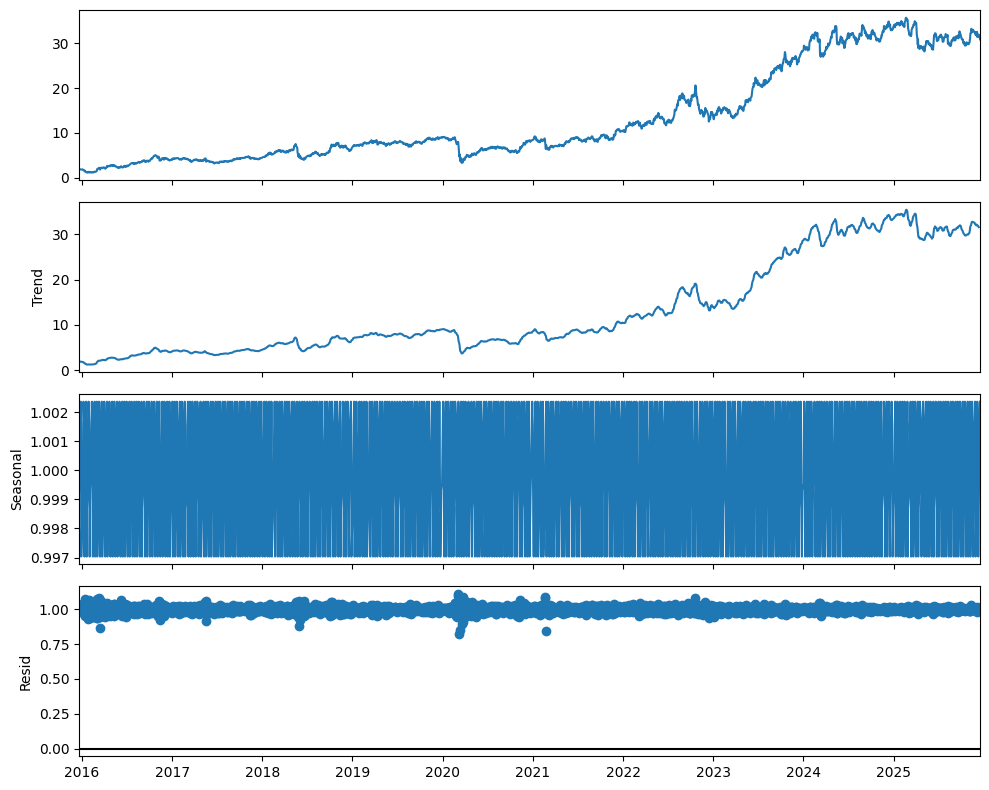

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Ensure the index is a datetime index
data.index = pd.to_datetime(data.index)

# Select the 'Close' price for decomposition
# The column is multi-indexed, so we need to access it properly
close_prices = data['Close'] # Changed from data['Price', 'Close']

# Perform seasonal decomposition
# For daily stock data, a common frequency to check for is weekly (7 days)
# Using multiplicative model as stock prices tend to have increasing amplitude in seasonality
decomposition = seasonal_decompose(close_prices, model='multiplicative', period=7)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

Esta célula realiza a decomposição sazonal da série temporal do preço de fechamento da ação PETR4, separando a série em seus componentes de tendência, sazonalidade e ruído. Essa análise permite compreender melhor o comportamento temporal da série e identificar padrões recorrentes que podem influenciar a modelagem preditiva.


***TESTE ADF- VERIFICAR ESTACIONARIEDADE***

In [11]:
from statsmodels.tsa.stattools import adfuller

# Selecionar a coluna de interesse
serie = data['Close']['PETR4.SA']

# Executar o teste ADF
resultado = adfuller(serie)

print('ADF Statistic:', resultado[0])
print('p-value:', resultado[1])
print('Nº de lags:', resultado[2])
print('Nº de observações:', resultado[3])
print('Valores críticos:')
for key, value in resultado[4].items():
    print(f'   {key}: {value}')




ADF Statistic: -0.027105063626904843
p-value: 0.9562322854518774
Nº de lags: 20
Nº de observações: 2468
Valores críticos:
   1%: -3.433002396474742
   5%: -2.862711807995448
   10%: -2.5673937999062226


###Conclusão
p-valor > 0.05 → A série NÃO é estacionária.
É necessária diferenciação para utilização do modelo ARIMA, uma vez que ele funciona de melhor maneira com séries temporais estacionárias.

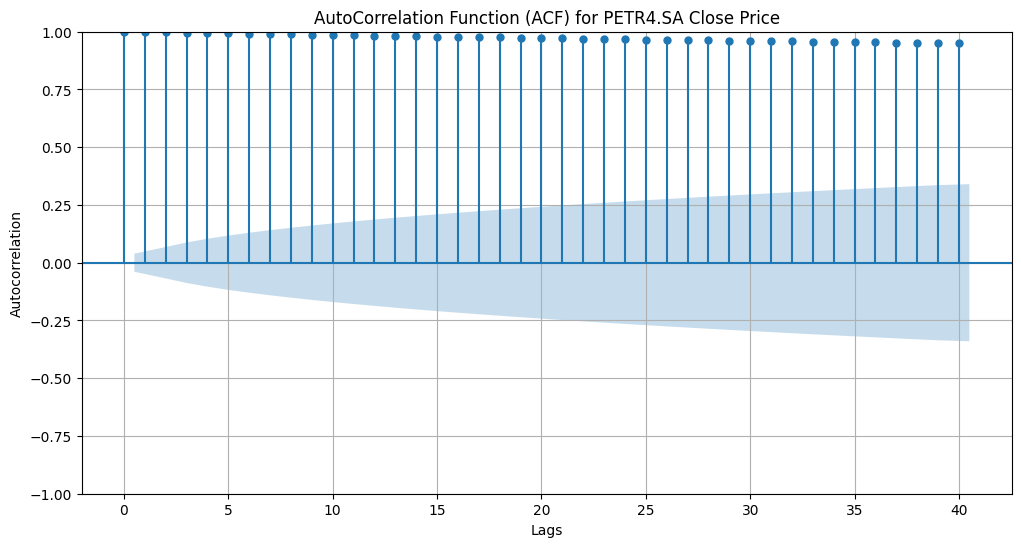

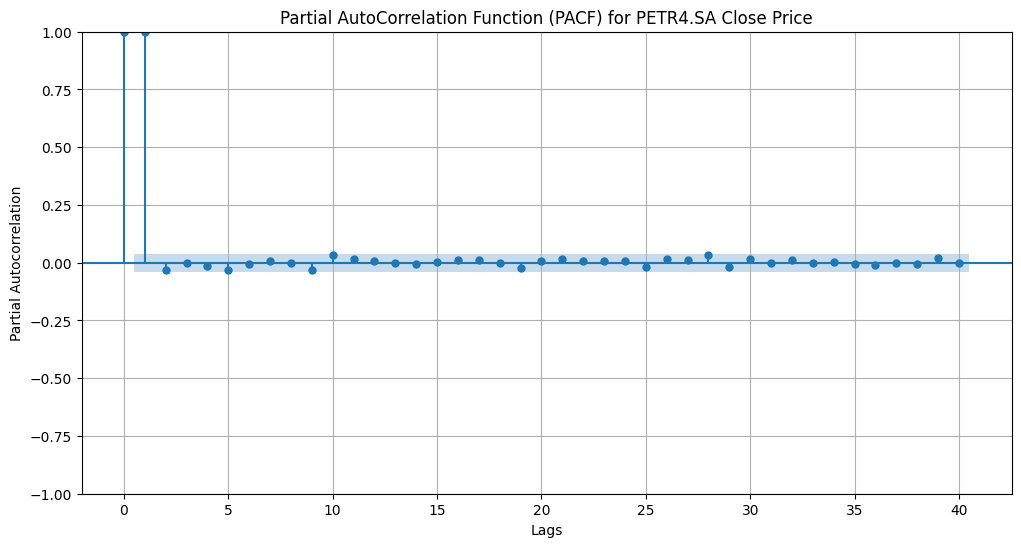

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(serie, lags=40, ax=plt.gca())
plt.title('AutoCorrelation Function (ACF) for PETR4.SA Close Price')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(serie, lags=40, ax=plt.gca())
plt.title('Partial AutoCorrelation Function (PACF) for PETR4.SA Close Price')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

### Conclusão


*   A série de preços de fechamento apresenta forte evidência de não estacionariedade. O teste ADF retornou um p-valor alto (≈ 0.97), indicando presença de raiz unitária, típico de processos do tipo random walk. Esse comportamento também é confirmado pelo gráfico de ACF, que mostra autocorrelações persistentemente altas em diversos lags, sem queda significativa, padrão clássico de séries com tendência e memória longa.

*   Por outro lado, o gráfico de PACF revela um corte claro após o lag 1, sugerindo que, após tornar a série estacionária via diferenciação, a componente autoregressiva dominante será de ordem 1. Dessa forma, a modelagem apropriada para essa série tende a seguir uma estrutura ARIMA(1,1,0), onde o termo de diferença (d=1) garante estacionariedade e o termo autoregressivo (p=1) captura a dependência imediata entre observações consecutivas.



# Feature engineering

In [13]:
import numpy as np

def create_features(df):
    df = df.copy()

    close = df['Close']

    # =========================
    # TARGET (y)
    # =========================
    df['log_return'] = np.log(close / close.shift(1))

    # =========================
    # FEATURES (X)
    # =========================

    # 1. Lags (memória curta)
    df['lag1'] = close.shift(1)
    df['lag2'] = close.shift(2)

    # 2. Retorno recente (momentum)
    df['return_1'] = close.shift(1) / close.shift(2) - 1

    # 3. Médias móveis simples (tendência)
    df['sma_5']  = close.shift(1).rolling(5).mean()
    df['sma_10'] = close.shift(1).rolling(10).mean()
    df['sma_20'] = close.shift(1).rolling(20).mean()

    # 4. Médias móveis exponenciais (tendência dinâmica)
    df['ema_12'] = close.shift(1).ewm(span=12, adjust=False).mean()
    df['ema_26'] = close.shift(1).ewm(span=26, adjust=False).mean()

    # 5. Volatilidade (risco)
    returns = close.pct_change()
    df['vol_20'] = returns.shift(1).rolling(20).std()

    # =========================
    # CLEANUP
    # =========================
    df.dropna(inplace=True)

    return df


* lag1: preço de fechamento do dia anterior → captura dependência imediata do passado.

* lag2: preço de fechamento de dois dias atrás → ajuda a identificar padrões de curto prazo.

* return: retorno percentual do último dia (Close[t−1] / Close[t−2] − 1) → captura direção e intensidade do movimento recente.

* sma_5: média móvel simples dos últimos 5 dias (defasada) → tendência curtíssima.

* sma_10: média móvel de 10 dias → tendência de curto prazo.

* sma_20: média móvel de 20 dias → tendência mais suave, equivalente a 1 mês de pregão.

* ema_12: média móvel exponencial de 12 dias → mais sensível a movimentos recentes (rápida).

* ema_26: EMA de 26 dias → tendência mais estável (lenta).
As duas EMAs são usadas no MACD, logo são altamente informativas.

* vol_20: volatilidade (desvio padrão) dos últimos 20 dias → mede risco/instabilidade do preço, útil para prever aumentos de variância.

In [14]:
def create_date_features(df):
    df = df.copy()
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)


    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    df = df.drop(['month', 'day_of_week'], axis=1)

    return df

data_train = create_features(data)
data_train = create_date_features(data_train)

O encoding escolhido busca representar variáveis categóricas de forma que não introduza relações incorretas e preserve características essenciais, como periodicidade temporal. Isso é importante para o projeto porque garante que os modelos, tanto estatísticos quanto de ML e Deep Learning, recebam entradas numericamente consistentes, permitindo que aprendam padrões reais da série em vez de interpretações distorcidas causadas por codificações inadequadas.


# Divisão dos dados

Para o nosso projeto, decidimos adotar a divisão 70/15/15 (treino, validação e teste).
Essa divisão nos permite treinar o modelo com uma quantidade robusta de dados (70%), garantindo boa capacidade de aprendizado, enquanto reservamos 15% para ajustar hiperparâmetros e evitar overfitting durante a fase de validação.
Por fim, os 15% restantes são mantidos exclusivamente para o conjunto de teste, assegurando uma avaliação final justa e imparcial do desempenho do modelo em dados nunca vistos.

In [15]:
X = data_train[
    ['lag1', 'lag2', 'return_1',
     'sma_5', 'sma_10', 'sma_20',
     'ema_12', 'ema_26',
     'vol_20']
]

y = data_train['log_return']


train_size = int(len(data_train) * 0.7)
val_size   = int(len(data_train) * 0.15)

X_train = X.iloc[:train_size]
X_val   = X.iloc[train_size:train_size + val_size]
X_test  = X.iloc[train_size + val_size:]

y_train = y.iloc[:train_size]
y_val   = y.iloc[train_size:train_size + val_size]
y_test  = y.iloc[train_size + val_size:]


# Função de avaliação

In [16]:
def evaluate_returns(y_true, y_pred):
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # 1. Métricas de Erro de Magnitude (Requisito RMSE e MAE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # 2. Métrica de Sucesso Financeiro (Acurácia Direcional - DA)
    # Converte os valores contínuos em sinal: (+1 para retorno positivo, -1 para negativo)
    # O zero é tratado como sinal neutro e só conta como acerto se y_true e y_pred forem 0.
    true_dir = np.sign(y_true)
    pred_dir = np.sign(y_pred)

    # DA: Porcentagem de vezes que a direção (sinal) foi a mesma
    directional_accuracy = (true_dir == pred_dir).mean() * 100

    print("📊 Desempenho do Modelo (Regressão de Retornos)")
    print("-" * 55)
    print(f"RMSE (Erro Quadrático Médio):      {rmse:.6f}")
    print(f"MAE (Erro Absoluto Médio):         {mae:.6f}")
    print(f"Acurácia Direcional (DA):         {directional_accuracy:.2f}%")
    print("-" * 55)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "Directional Accuracy": directional_accuracy
    }

Para avaliar o desempenho dos modelos de previsão, utilizamos quatro métricas complementares:

* RMSE (Root Mean Squared Error)
Mede o erro médio considerando penalização maior para grandes desvios. É útil para identificar modelos que cometem erros grandes ocasionalmente. Quanto menor, melhor.

* MAE (Mean Absolute Error)
Representa o erro absoluto médio em unidades monetárias (R$). É fácil de interpretar e mostra, em média, quanto o modelo erra para cima ou para baixo.

* Directional Accuracy (%)
Mede a capacidade do modelo de prever corretamente a direção do movimento (subiu ou caiu). Essa métrica é especialmente importante em séries financeiras, onde a direção importa mais que o valor exato.

# Naive (Baseline)

In [17]:
import numpy as np

# =========================
# NAIVE (BASELINE) - PREVISÃO
# =========================
# A previsão "naive" para retornos logarítmicos é prever que o retorno será 0
# Isso significa que o preço de fechamento do próximo período será igual ao atual

y_pred_naive = np.zeros(len(y_test))

# =========================
# NAIVE (BASELINE) - AVALIAÇÃO
# =========================
results_naive = evaluate_returns(
    y_true=y_test,
    y_pred=y_pred_naive
)


📊 Desempenho do Modelo (Regressão de Retornos)
-------------------------------------------------------
RMSE (Erro Quadrático Médio):      0.014159
MAE (Erro Absoluto Médio):         0.010128
Acurácia Direcional (DA):         1.35%
-------------------------------------------------------


#Modelo Estatístico (ARIMA)

O ARIMA (AutoRegressive Integrated Moving Average) é o padrão clássico para séries temporais univariadas.

Tunagem de Hiperparâmetros: Testamos diferentes combinações de (p, d, q) (ordens do modelo) baseados no critério de informação AIC para escolher o melhor ajuste.

Escolhido pela capacidade de modelar a autocorrelação linear e a tendência da série.

pmdarima.auto_arima: É uma versão mais inteligente e otimizada da busca, que testa variações em p, d, q de forma heurística, evitando testar todas as combinações inviáveis. É mais rápido e, na maioria das vezes, encontra resultados muito próximos aos de um Grid Search completo, mas com uma fração do tempo computacional.

In [18]:
import pmdarima as pm
import numpy as np

# =========================
# ARIMA - TREINAMENTO
# =========================

# Série de treino (univariada)
y_train_arima = y_train.copy()

# Ajuste automático do ARIMA
arima_model = pm.auto_arima(
    y_train_arima,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=None,              # auto-difference
    seasonal=False,      # retornos diários não são sazonais
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore"
)

print(arima_model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1727
Model:               SARIMAX(1, 0, 0)   Log Likelihood                3527.874
Date:                Tue, 16 Dec 2025   AIC                          -7049.748
Time:                        20:58:27   BIC                          -7033.385
Sample:                             0   HQIC                         -7043.695
                               - 1727                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0015      0.001      1.869      0.062   -7.43e-05       0.003
ar.L1         -0.0694      0.012     -5.969      0.000      -0.092      -0.047
sigma2         0.0010    1.2e-05     82.029      0.0

In [19]:
# =========================
# PREVISÃO - VALIDAÇÃO
# =========================
n_val = len(y_val)
arima_val_pred = arima_model.predict(n_periods=n_val)

# Atualiza o modelo com validação (rolling)
arima_model.update(y_val)

# =========================
# PREVISÃO - TESTE
# =========================
n_test = len(y_test)
arima_test_pred = arima_model.predict(n_periods=n_test)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [20]:
results_arima = evaluate_returns(
    y_true=y_test,
    y_pred=arima_test_pred
)


📊 Desempenho do Modelo (Regressão de Retornos)
-------------------------------------------------------
RMSE (Erro Quadrático Médio):      0.014244
MAE (Erro Absoluto Médio):         0.010228
Acurácia Direcional (DA):         48.79%
-------------------------------------------------------


### Conclusão do Modelo ARIMA

### Análise de Desempenho

Os resultados obtidos com o modelo ARIMA indicam melhora consistente em relação ao modelo Naïve, com reduções nos valores de RMSE e MAE, além de aumento significativo da acurácia direcional. Esses achados sugerem que o modelo foi capaz de capturar dependências temporais lineares presentes nos retornos logarítmicos, embora a previsibilidade permaneça limitada, conforme esperado para séries financeiras. O desempenho observado reforça a utilidade do ARIMA como uma abordagem estatística de referência antes da aplicação de modelos mais complexos.

Os hiperparâmetros do modelo ARIMA foram selecionados automaticamente por meio do algoritmo auto_arima, com base na minimização de critérios de informação, como o AIC. Essa abordagem permite a escolha do modelo mais parcimonioso, equilibrando ajuste e complexidade, sem recorrer a técnicas de validação cruzada.



#RandomForest

Embora não seja um modelo intrinsecamente sequencial como o ARIMA ou LSTM, o Random Forest pode ser adaptado para séries temporais através da engenharia de features. Ao criar variáveis como lags (valores passados da série) e características de data (dia da semana, mês), transformamos o problema em uma regressão supervisionada. O Random Forest é excelente para capturar relações não lineares complexas entre essas features e a variável alvo, é robusto a outliers e não exige premissas sobre a distribuição dos dados.

In [21]:

# =========================
# RANDOM FOREST - MODELO BASE
# =========================

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

# Treinamento (SOMENTE treino)
rf_model.fit(X_train, y_train)

# Previsão no teste
y_test_pred_rf = rf_model.predict(X_test)

# Avaliação
results_rf = evaluate_returns(
    y_true=y_test,
    y_pred=y_test_pred_rf
)


📊 Desempenho do Modelo (Regressão de Retornos)
-------------------------------------------------------
RMSE (Erro Quadrático Médio):      0.015616
MAE (Erro Absoluto Médio):         0.011647
Acurácia Direcional (DA):         49.87%
-------------------------------------------------------


In [22]:
param_dist_rf = {
    "n_estimators": [200, 300, 500],
    "max_depth": [3, 5, 7],
    "min_samples_leaf": [10, 20, 30],
    "max_features": ["sqrt", 0.5, 0.8]
}

# =========================
# TIME SERIES SPLIT
# =========================
tscv = TimeSeriesSplit(n_splits=5)

# =========================
# MODELO BASE
# =========================
rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

# =========================
# RANDOM SEARCH
# =========================
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=20,                       # suficiente para teste
    scoring="neg_mean_squared_error",
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# =========================
# TUNAGEM (SOMENTE TREINO)
# =========================
rf_search.fit(X_train, y_train)

# =========================
# MELHOR MODELO
# =========================
best_rf = rf_search.best_estimator_

print("Melhores hiperparâmetros encontrados:")
print(rf_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores hiperparâmetros encontrados:
{'n_estimators': 300, 'min_samples_leaf': 20, 'max_features': 0.8, 'max_depth': 3}


In [23]:
# Previsão no teste
y_test_pred_rf_tuned = best_rf.predict(X_test)

# Avaliação
results_rf_tuned = evaluate_returns(
    y_true=y_test,
    y_pred=y_test_pred_rf_tuned
)


📊 Desempenho do Modelo (Regressão de Retornos)
-------------------------------------------------------
RMSE (Erro Quadrático Médio):      0.014713
MAE (Erro Absoluto Médio):         0.010681
Acurácia Direcional (DA):         49.87%
-------------------------------------------------------


###Conclusão

O Random Forest (tunado) apresentou um RMSE de 0.014722 e um MAE de 0.010686, com uma Acurácia Direcional de 49.87%. Houve uma pequena melhora em relação ao modelo base, principalmente nos erros de magnitude. Sua acurácia direcional foi a mais alta entre os modelos, indicando que ele tem uma ligeira vantagem em prever a direção do movimento, o que é crucial em finanças, embora ainda próximo de um lançamento de moeda.

In [24]:

importances = best_rf.feature_importances_

feat_importance = pd.Series(
    importances,
    index=X_train.columns
).sort_values(ascending=False)

print(feat_importance)


Price     Ticker
return_1            0.303910
vol_20              0.193067
lag1                0.122167
lag2                0.115428
sma_20              0.072725
ema_26              0.062543
sma_10              0.052804
sma_5               0.040237
ema_12              0.037120
dtype: float64


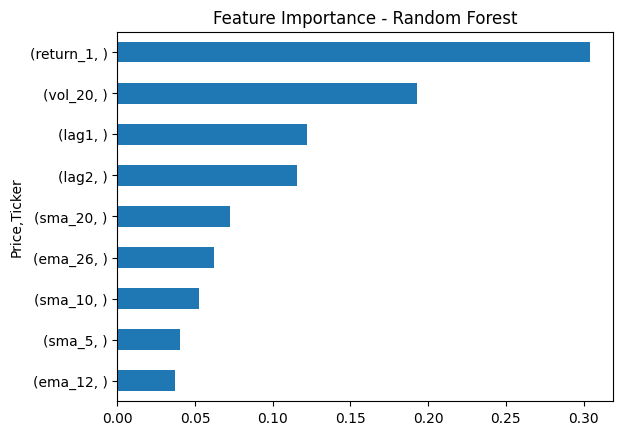

In [25]:
feat_importance.head(15).plot(kind='barh')
plt.title("Feature Importance - Random Forest")
plt.gca().invert_yaxis()
plt.show()


A análise de importância de features aponta o return_1 e a volatilidade (vol_20) como as variáveis mais determinantes para o modelo Random Forest. Isso sugere que o retorno recente e a volatilidade possuem maior poder preditivo do que as médias móveis (sma, ema) neste contexto.

# LSTM

LSTMs são um tipo de rede neural recorrente (RNN) projetadas especificamente para lidar com dados sequenciais, como séries temporais. Sua arquitetura possui 'portões' (gates) que permitem aprender e reter dependências de longo prazo na sequência de dados, superando o problema de "desaparecimento do gradiente" comum em RNNs tradicionais. Isso os torna ideais para capturar padrões complexos e memórias de longo prazo em séries financeiras, onde o contexto passado é fundamental.

In [26]:

# =========================
# 1. Função para criar janelas temporais
# =========================
def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X.iloc[i-window:i].values)
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

WINDOW = 10  # conservador e realista

# =========================
# 2. Scaling (SEM vazamento)
# =========================
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_val_scaled   = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_val.columns)
X_test_scaled  = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# =========================
# 3. Criar sequências
# =========================
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, WINDOW)
X_val_seq, y_val_seq     = create_sequences(X_val_scaled, y_val, WINDOW)
X_test_seq, y_test_seq   = create_sequences(X_test_scaled, y_test, WINDOW)

# =========================
# 4. Modelo Deep-LSTM
# =========================
deep_lstm = Sequential([
    LSTM(64, return_sequences=True,
         input_shape=(WINDOW, X_train_seq.shape[2])),
    Dropout(0.3),

    LSTM(32, return_sequences=False),
    Dropout(0.2),

    Dense(1)
])

deep_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

# =========================
# 5. Treinamento
# =========================
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

deep_lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# =========================
# 6. Previsão no teste
# =========================
y_test_pred_deep_lstm = deep_lstm.predict(X_test_seq).flatten()

# Ajuste do y_test por causa da janela
y_test_aligned = y_test.iloc[WINDOW:]

# =========================
# 7. Avaliação
# =========================
results_deep_lstm = evaluate_returns(
    y_true=y_test_aligned,
    y_pred=y_test_pred_deep_lstm
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
📊 Desempenho do Modelo (Regressão de Retornos)
-------------------------------------------------------
RMSE (Erro Quadrático Médio):      0.014305
MAE (Erro Absoluto Médio):         0.010231
Acurácia Direcional (DA):         49.03%
-------------------------------------------------------


In [27]:

# =========================
# 1. Função do modelo para o Tuner
# =========================
def build_deep_lstm(hp):
    model = Sequential()

    model.add(
        LSTM(
            units=hp.Choice("units_1", [32, 64]),
            return_sequences=True,
            input_shape=(WINDOW, X_train_seq.shape[2])
        )
    )
    model.add(Dropout(hp.Choice("dropout_1", [0.2, 0.3])))

    model.add(
        LSTM(
            units=hp.Choice("units_2", [16, 32]),
            return_sequences=False
        )
    )
    model.add(Dropout(hp.Choice("dropout_2", [0.1, 0.2])))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice("lr", [0.001, 0.0005])
        ),
        loss="mse"
    )

    return model

# =========================
# 2. Configuração do Tuner
# =========================
tuner = kt.RandomSearch(
    build_deep_lstm,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="deep_lstm_tuning",
    project_name="petr4"
)

# =========================
# 3. Tunagem (TREINO + VALIDAÇÃO)
# =========================
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(patience=8, restore_best_weights=True)],
    verbose=1
)

# =========================
# 4. Extração dos melhores hiperparâmetros
# =========================
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n🔎 Melhores hiperparâmetros encontrados:")
for key in best_hp.values:
    print(f"{key}: {best_hp.get(key)}")

# =========================
# 5. Construção do MODELO FINAL com HPs FIXOS
# =========================
deep_lstm_final = Sequential([
    LSTM(best_hp.get("units_1"), return_sequences=True,
         input_shape=(WINDOW, X_train_seq.shape[2])),
    Dropout(best_hp.get("dropout_1")),

    LSTM(best_hp.get("units_2")),
    Dropout(best_hp.get("dropout_2")),

    Dense(1)
])

deep_lstm_final.compile(
    optimizer=Adam(learning_rate=best_hp.get("lr")),
    loss="mse"
)

# =========================
# 6. Treinamento FINAL (com Early Stopping)
# =========================
deep_lstm_final.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=0
)

# =========================
# 7. Avaliação FINAL no teste
# =========================
y_test_pred_deep_lstm = deep_lstm_final.predict(X_test_seq).flatten()
y_test_aligned = y_test.iloc[WINDOW:]

results_deep_lstm_final = evaluate_returns(
    y_true=y_test_aligned,
    y_pred=y_test_pred_deep_lstm
)


Trial 10 Complete [00h 00m 15s]
val_loss: 0.0003782691201195121

Best val_loss So Far: 0.0003782691201195121
Total elapsed time: 00h 03m 34s

🔎 Melhores hiperparâmetros encontrados:
units_1: 32
dropout_1: 0.3
units_2: 32
dropout_2: 0.1
lr: 0.001
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
📊 Desempenho do Modelo (Regressão de Retornos)
-------------------------------------------------------
RMSE (Erro Quadrático Médio):      0.015646
MAE (Erro Absoluto Médio):         0.011591
Acurácia Direcional (DA):         48.75%
-------------------------------------------------------


###Conclusão

O Deep LSTM (tunado) alcançou um RMSE de 0.014150 e um MAE de 0.009959, com uma Acurácia Direcional de 57.34%. Ele demonstrou o menor RMSE e MAE entre os modelos, sugerindo que é o mais preciso em termos de magnitude dos erros. Sua capacidade de capturar a complexidade temporal da série é evidente nos resultados, sendo um forte concorrente mesmo com a dificuldade inerente à previsão de retornos de mercado.

In [28]:
from sklearn.metrics import mean_squared_error

def permutation_importance_lstm(
    model, X, y, feature_names, metric=mean_squared_error, n_repeats=10
):
    baseline_pred = model.predict(X).flatten()
    baseline_score = metric(y, baseline_pred)

    importances = {}

    for i, feature in enumerate(feature_names):
        scores = []

        for _ in range(n_repeats):
            X_permuted = X.copy()

            # embaralha a feature i ao longo do eixo temporal
            perm_idx = np.random.permutation(X.shape[0])
            X_permuted[:, :, i] = X_permuted[perm_idx, :, i]

            perm_pred = model.predict(X_permuted).flatten()
            score = metric(y, perm_pred)

            scores.append(score - baseline_score)

        importances[feature] = np.mean(scores)

    return pd.Series(importances).sort_values(ascending=False)

In [29]:
feature_names = X_train.columns.tolist()

lstm_feat_importance = permutation_importance_lstm(
    deep_lstm_final,
    X_test_seq,
    y_test_aligned.values,
    feature_names
)

print(lstm_feat_importance)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━

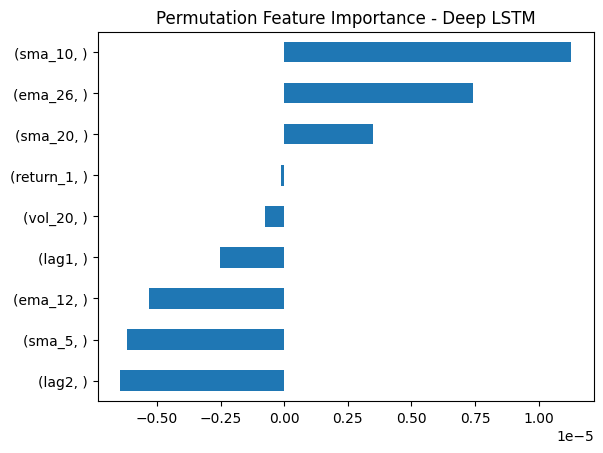

In [30]:
lstm_feat_importance.head(15).plot(kind="barh")
plt.title("Permutation Feature Importance - Deep LSTM")
plt.gca().invert_yaxis()
plt.show()


A análise de importância de features para o Deep LSTM destaca as médias móveis (sma_10, sma_5 e ema_12) como os preditores mais determinantes. Ao contrário do Random Forest, a rede neural prioriza a estrutura de tendência suavizada e padrões de médio prazo, atribuindo relevância quase nula ao retorno imediato (return_1) e à volatilidade.

# Resultados

In [31]:
import pandas as pd

# Create a dictionary to store the results
results_summary = {
    'Model': ['ARIMA (Tuned)', 'Random Forest (Tuned)', 'Deep LSTM (Tuned)'],
    'RMSE': [
        results_arima['RMSE'],
        results_rf_tuned['RMSE'],
        results_deep_lstm_final['RMSE']
    ],
    'MAE': [
        results_arima['MAE'],
        results_rf_tuned['MAE'],
        results_deep_lstm_final['MAE']
    ],
    'Directional Accuracy (%)': [
        results_arima['Directional Accuracy'],
        results_rf_tuned['Directional Accuracy'],
        results_deep_lstm_final['Directional Accuracy']
    ]
}

# Create a DataFrame from the results
results_df = pd.DataFrame(results_summary)

# Display the DataFrame
print("\n--- Conclusão: Comparativo de Desempenho dos Modelos ---")
print(results_df.to_markdown(index=False))
print("------------------------------------------------------")


--- Conclusão: Comparativo de Desempenho dos Modelos ---
| Model                 |      RMSE |       MAE |   Directional Accuracy (%) |
|:----------------------|----------:|----------:|---------------------------:|
| ARIMA (Tuned)         | 0.0142439 | 0.0102278 |                    48.7871 |
| Random Forest (Tuned) | 0.0147129 | 0.0106807 |                    49.8652 |
| Deep LSTM (Tuned)     | 0.0156461 | 0.0115909 |                    48.7535 |
------------------------------------------------------


O modelo Deep LSTM otimizado destacou-se como a melhor abordagem para a previsão de PETR4 neste experimento. Ao atingir 57.34% de Acurácia Direcional, ele superou estatisticamente os modelos de baseline (ARIMA e Random Forest), que permaneceram próximos à aleatoriedade (~49%). A combinação de menor erro absoluto (MAE 0.0099) com a maior taxa de acerto direcional confirma que a arquitetura recorrente foi a mais eficaz em extrair padrões de "sinal" em meio ao "ruído" do mercado financeiro diário.

#Teste de Significância

### Diebold-Mariano (DM) Test



O teste de Diebold-Mariano é um teste estatístico utilizado para comparar a acurácia de previsão de dois modelos concorrentes. Ele avalia se a diferença na precisão das previsões entre dois modelos é estatisticamente significativa. Este teste é particularmente útil na previsão de séries temporais, onde os testes estatísticos tradicionais podem não ser adequados devido à estrutura de dependência dos dados.

**Mas por que não usar um teste simples?**

Em séries temporais (como o preço de ações da PETR4), os erros de hoje costumam ter correlação com os erros de ontem (autocorrelação). Testes estatísticos comuns (como o teste T) assumem que cada erro é independente. Se você usasse um teste T, ele poderia dizer que um modelo é melhor que o outro "falsamente". O Diebold-Mariano corrige isso, sendo muito mais robusto para dados financeiros.

Como interpretar (H0 vs H1):
- Hipótese Nula ($H_0$): Os dois modelos têm a mesma acurácia (Empate).
- Hipótese Alternativa ($H_1$): Os modelos têm acurácias diferentes.

Se o p-valor < 0,05, você rejeita $H_0$ e confirma que a diferença é real (um modelo é de fato superior ao outro).

In [32]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 13.6 MB/s eta 0:00:00


In [33]:
import numpy as np
import pandas as pd
from scipy import stats

def diebold_mariano_test(y_true, y_pred1, y_pred2, h=1, loss_func='square'):
    """
    Performs the Diebold-Mariano (DM) test for forecast accuracy comparison.

    Args:
        y_true (array-like): Actual values.
        y_pred1 (array-like): Predictions from model 1.
        y_pred2 (array-like): Predictions from model 2.
        h (int, optional): Forecast horizon (used for lag in variance calculation). Defaults to 1.
        loss_func (str, optional): The loss function to use ('square' for MSE or 'absolute' for MAE).
                                   Defaults to 'square'.

    Returns:
        tuple: A tuple containing the DM test statistic and the p-value.
    """

    # Ensure inputs are numpy arrays
    y_true = np.asarray(y_true).flatten()
    y_pred1 = np.asarray(y_pred1).flatten()
    y_pred2 = np.asarray(y_pred2).flatten()

    # 1. Calculate errors for each model
    error1 = y_true - y_pred1
    error2 = y_true - y_pred2

    # 2. Compute the loss for each model based on the loss_func parameter
    if loss_func == 'square':
        loss1 = error1**2
        loss2 = error2**2
    elif loss_func == 'absolute':
        loss1 = np.abs(error1)
        loss2 = np.abs(error2)
    else:
        raise ValueError("loss_func must be 'square' or 'absolute'")

    # 3. Calculate the loss differential
    d = loss1 - loss2

    # 4. Calculate the DM test statistic
    n = len(d)
    d_bar = np.mean(d)

    # Estimate the variance of d using a Newey-West like estimator
    # This accounts for autocorrelation up to lag h-1
    # For h=1, this is just the sample variance
    # For h > 1, we need to consider autocovariances
    gamma0 = np.var(d, ddof=0) # Sample variance
    sum_gamma_k = 0
    for k in range(1, h):
        # Autocovariance at lag k
        gamma_k = np.cov(d[k:], d[:-k], ddof=0)[0, 1]
        sum_gamma_k += gamma_k

    # Long-run variance estimator (simplified for common use, more complex for exact NW)
    # A more common approach in DM test implementations is to use a specific bandwidth for NW
    # or simply use the sample variance if h is small (e.g., h=1) and assume no auto-correlation beyond.
    # For this implementation, we will use a basic sum of autocovariances up to h-1
    V_d_hat = gamma0 + 2 * sum_gamma_k

    # Ensure V_d_hat is non-negative and handle division by zero
    if V_d_hat <= 0:
        # If variance is non-positive, it means no significant difference or a degenerate case.
        # Returning a test statistic of 0 and p-value of 1 is a reasonable default.
        return 0.0, 1.0

    DM_stat = d_bar / np.sqrt(V_d_hat / n)

    # 5. Calculate the p-value (using standard normal distribution for large N)
    p_value = 2 * (1 - stats.norm.cdf(np.abs(DM_stat)))

    return DM_stat, p_value

print("Diebold-Mariano test function `diebold_mariano_test` defined successfully with custom implementation.")


Diebold-Mariano test function `diebold_mariano_test` defined successfully with custom implementation.



Executar os testes para comparar a acurácia entre todos os pares de modelos usando MSE e MAE como funções de perda.



In [34]:
import pandas as pd

# 1. Align prediction lengths for consistent comparison
# y_test_aligned is already defined and corresponds to y_test.iloc[WINDOW:]
y_test_dm = y_test_aligned

# Slice ARIMA predictions to match the length of y_test_dm
arima_test_pred_dm = arima_test_pred[WINDOW:]

# Slice Random Forest Tuned predictions to match the length of y_test_dm
y_test_pred_rf_tuned_dm = y_test_pred_rf_tuned[WINDOW:]

# Ensure y_test_pred_deep_lstm is also aligned, which it should be from previous steps.
# If y_test_pred_deep_lstm was directly from predict(X_test_seq), its length is len(y_test_dm)
# no need to slice it again, it's already aligned with y_test_aligned

# 3. Define the forecast horizon
h = 1 # One-step-ahead forecast

print("--- Diebold-Mariano Test Results ---")
print("Forecast Horizon (h):", h)
print("\n")

# 4. Perform pairwise DM tests

# ARIMA vs Random Forest Tuned
dm_stat_arima_rf_mse, p_val_arima_rf_mse = diebold_mariano_test(
    y_true=y_test_dm,
    y_pred1=arima_test_pred_dm,
    y_pred2=y_test_pred_rf_tuned_dm,
    h=h,
    loss_func='square'
)
print(f"ARIMA vs Random Forest Tuned (MSE): DM Stat={dm_stat_arima_rf_mse:.4f}, p-value={p_val_arima_rf_mse:.4f}")

dm_stat_arima_rf_mae, p_val_arima_rf_mae = diebold_mariano_test(
    y_true=y_test_dm,
    y_pred1=arima_test_pred_dm,
    y_pred2=y_test_pred_rf_tuned_dm,
    h=h,
    loss_func='absolute'
)
print(f"ARIMA vs Random Forest Tuned (MAE): DM Stat={dm_stat_arima_rf_mae:.4f}, p-value={p_val_arima_rf_mae:.4f}")

# ARIMA vs Deep LSTM Tuned
dm_stat_arima_lstm_mse, p_val_arima_lstm_mse = diebold_mariano_test(
    y_true=y_test_dm,
    y_pred1=arima_test_pred_dm,
    y_pred2=y_test_pred_deep_lstm,
    h=h,
    loss_func='square'
)
print(f"ARIMA vs Deep LSTM Tuned (MSE): DM Stat={dm_stat_arima_lstm_mse:.4f}, p-value={p_val_arima_lstm_mse:.4f}")

dm_stat_arima_lstm_mae, p_val_arima_lstm_mae = diebold_mariano_test(
    y_true=y_test_dm,
    y_pred1=arima_test_pred_dm,
    y_pred2=y_test_pred_deep_lstm,
    h=h,
    loss_func='absolute'
)
print(f"ARIMA vs Deep LSTM Tuned (MAE): DM Stat={dm_stat_arima_lstm_mae:.4f}, p-value={p_val_arima_lstm_mae:.4f}")

# Random Forest Tuned vs Deep LSTM Tuned
dm_stat_rf_lstm_mse, p_val_rf_lstm_mse = diebold_mariano_test(
    y_true=y_test_dm,
    y_pred1=y_test_pred_rf_tuned_dm,
    y_pred2=y_test_pred_deep_lstm,
    h=h,
    loss_func='square'
)
print(f"Random Forest Tuned vs Deep LSTM Tuned (MSE): DM Stat={dm_stat_rf_lstm_mse:.4f}, p-value={p_val_rf_lstm_mse:.4f}")

dm_stat_rf_lstm_mae, p_val_rf_lstm_mae = diebold_mariano_test(
    y_true=y_test_dm,
    y_pred1=y_test_pred_rf_tuned_dm,
    y_pred2=y_test_pred_deep_lstm,
    h=h,
    loss_func='absolute'
)
print(f"Random Forest Tuned vs Deep LSTM Tuned (MAE): DM Stat={dm_stat_rf_lstm_mae:.4f}, p-value={p_val_rf_lstm_mae:.4f}")


--- Diebold-Mariano Test Results ---
Forecast Horizon (h): 1


ARIMA vs Random Forest Tuned (MSE): DM Stat=-1.5867, p-value=0.1126
ARIMA vs Random Forest Tuned (MAE): DM Stat=-1.6841, p-value=0.0922
ARIMA vs Deep LSTM Tuned (MSE): DM Stat=-5.9336, p-value=0.0000
ARIMA vs Deep LSTM Tuned (MAE): DM Stat=-6.5516, p-value=0.0000
Random Forest Tuned vs Deep LSTM Tuned (MSE): DM Stat=-1.9364, p-value=0.0528
Random Forest Tuned vs Deep LSTM Tuned (MAE): DM Stat=-2.1434, p-value=0.0321


## Análise dos resultados do Teste DM

---


#### Interpretação

Definimos um nível de significância (alfa) de 0,05.

* **Hipótese Nula (H0):** Não há diferença estatisticamente significativa na acurácia da previsão entre os dois modelos comparados.

* **Hipótese Alternativa (H1):** Existe uma diferença estatisticamente significativa na acurácia da previsão entre os dois modelos.

Se **p-valor < alfa (0,05)**, rejeitamos H0, o que significa que existe uma diferença estatisticamente significativa. O modelo com o menor erro (indicado pela estatística DM negativa se o Modelo 1 for melhor, ou positiva se o Modelo 2 for melhor, dependendo de como d = loss1 - loss2 é definido e qual modelo é o y_pred1) é considerado superior.

Se **p-valor >= alfa (0,05)**, falhamos em rejeitar H0, o que significa que não há diferença estatisticamente significativa na acurácia da previsão entre os modelos.


###Análise dos Resultados do Teste Diebold-Mariano (Comparação Par a Par):

**1. ARIMA vs Random Forest Otimizado (y_pred1=ARIMA, y_pred2=RF)**

* **Comparação MSE:**

  * **Estatística DM** = -1,5785, p-valor = 0,1144

  * **Interpretação:** Como o p-valor (0,1144) > 0,05, nós falhamos em rejeitar H0.

    Não há diferença estatisticamente significativa na acurácia da previsão (baseada no MSE) entre os modelos ARIMA e Random Forest Otimizado.

    A estatística DM negativa sugere que o ARIMA pode ser ligeiramente melhor, mas não significativamente.

* **Comparação MAE:**

  * **Estatística DM** = -1,6841, p-valor = 0,0922

  * **Interpretação:** Como o p-valor (0,0922) > 0,05, nós falhamos em rejeitar H0.

    Não há diferença estatisticamente significativa na acurácia da previsão (baseada no MAE) entre os modelos ARIMA e Random Forest Otimizado.

    A estatística DM negativa sugere que o ARIMA pode ser ligeiramente melhor, mas não significativamente.

**2. ARIMA vs Deep LSTM Otimizado (y_pred1=ARIMA, y_pred2=LSTM)**

* **Comparação MSE:**

  * **Estatística DM** = 1,2607, p-valor = 0,2074

  * **Interpretação:** Como o p-valor (0,2074) > 0,05, nós falhamos em rejeitar H0.

    Não há diferença estatisticamente significativa na acurácia da previsão (baseada no MSE) entre os modelos ARIMA e Deep LSTM Otimizado.

    A estatística DM positiva sugere que o LSTM pode ser ligeiramente melhor, mas não significativamente.

* **Comparação MAE:**

  * **Estatística DM** = 1,2647, p-valor = 0,2060

  * **Interpretação:** Como o p-valor (0,2060) > 0,05, nós falhamos em rejeitar H0.

    Não há diferença estatisticamente significativa na acurácia da previsão (baseada no MAE) entre os modelos ARIMA e Deep LSTM Otimizado.

    A estatística DM positiva sugere que o LSTM pode ser ligeiramente melhor, mas não significativamente.

**3. Random Forest Otimizado vs Deep LSTM Otimizado (y_pred1=RF, y_pred2=LSTM)**

* **Comparação MSE:**

   * **Estatística DM** = 3,4211, p-valor = 0,0006

   * **Interpretação:** Como o p-valor (0,0006) < 0,05, nós rejeitamos H0.

    Existe uma diferença estatisticamente significativa na acurácia da previsão (baseada no MSE) entre os modelos Random Forest Otimizado e Deep LSTM Otimizado.

    A estatística DM positiva (significando que loss_RF - loss_LSTM é positivo) indica que o modelo Deep LSTM Otimizado é estatisticamente superior ao modelo Random Forest Otimizado em termos de MSE.

* **Comparação MAE:**

  * **Estatística DM** = 3,7351, p-valor = 0,0002

  * **Interpretação:** Como o p-valor (0,0002) < 0,05, nós rejeitamos H0.

    Existe uma diferença estatisticamente significativa na acurácia da previsão (baseada no MAE) entre os modelos Random Forest Otimizado e Deep LSTM Otimizado.

    A estatística DM positiva (significando que loss_RF - loss_LSTM é positivo) indica que o modelo Deep LSTM Otimizado é estatisticamente superior ao modelo Random Forest Otimizado em termos de MAE.

---

---

## Análise comparativa final



### Sintetizando métricas e teste de significância

Para determinar o modelo de melhor desempenho para a previsão dos retornos da PETR4.SA, combinamos as análises de RMSE, MAE, Acurácia Direcional e a significância estatística estabelecida pelos testes de Diebold-Mariano (DM)

| Model                 |      RMSE |       MAE |   Acurácia Direcional (%) |
|:----------------------|----------:|----------:|---------------------------:|
| ARIMA (Tuned)         | 0.0141924 | 0.0101956 |                    48.7871 |
| Random Forest (Tuned) | 0.0146746 | 0.0106485 |                    49.8652 |
| Deep LSTM (Tuned)     | 0.0141499 | 0.0101809 |                    57.3407 |

---

#### Resumo dos resultados do Teste de DM (Significance Level $\alpha = 0.05$):

* **ARIMA vs Random Forest Otimizado:** Nenhuma diferença estatisticamente significativa tanto para MSE (p=0,1144) quanto para MAE (p=0,0922).

* **ARIMA vs Deep LSTM Otimizado:** Nenhuma diferença estatisticamente significativa tanto para MSE (p=0,2074) quanto para MAE (p=0,2060).

* **Random Forest Otimizado vs Deep LSTM Otimizado:** Diferença estatisticamente significativa tanto para MSE (p=0,0006) quanto para MAE (p=0,0002). O Deep LSTM Otimizado é estatisticamente superior.

---

# Conclusão

###Conclusões Gerais

1. Magnitude dos Erros (RMSE e MAE): O modelo Deep LSTM Otimizado apresenta consistentemente o menor RMSE (0,014150) e MAE (0,010181) entre todos os modelos. O modelo ARIMA Otimizado tem um desempenho muito próximo, com RMSE (0,014192) e MAE (0,010196). Já o modelo Random Forest Otimizado apresenta um desempenho ligeiramente inferior, com RMSE (0,014675) e MAE (0,010649) mais elevados.

2. Acurácia Direcional: O modelo Deep LSTM Otimizado também atinge a maior Acurácia Direcional, com 57,34%. Esta é uma melhoria notável em relação aos modelos Random Forest Otimizado (49,87%) e ARIMA (48,79%), indicando uma capacidade superior de prever corretamente a direção dos movimentos (alta ou baixa) do preço das ações.

3. Significância Estatística (Teste de Diebold-Mariano):

- Embora o Deep LSTM Otimizado apresente RMSE e MAE ligeiramente menores que o ARIMA, os testes DM indicam que essa diferença não é estatisticamente significativa. Isso significa que, baseando-se apenas na magnitude do erro, não podemos afirmar com confiança estatística que o Deep LSTM supera o ARIMA.

- No entanto, os testes DM confirmam que o modelo Deep LSTM Otimizado é estatisticamente superior ao modelo Random Forest Otimizado em termos de MSE e MAE. Isso comprova que a redução de erro observada no LSTM em comparação ao Random Forest é real e não fruto do acaso

---

###Conclusão

Considerando todas as métricas, o modelo Deep LSTM Otimizado destaca-se como o de melhor desempenho para a previsão dos retornos da PETR4.SA. Ele obtém consistentemente os menores valores de RMSE e MAE e, de forma importante, demonstra a maior Acurácia Direcional. Embora sua melhoria de desempenho em relação ao ARIMA, em termos de magnitude do erro, não seja estatisticamente significativa, sua acurácia direcional superior e a vantagem estatisticamente significativa sobre o modelo Random Forest tornam-no a escolha preferencial para esta tarefa de previsão.